In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.layouts import widgetbox
from bokeh.models.widgets import DataTable, NumberFormatter, TableColumn
output_notebook()

from k_fold import cross_validation
from proj1_helpers import *
from implementations import *
from helpers import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Data exploration

In [3]:
y, x, ids = load_csv_data('../data/train.csv')
labels = np.array(np.genfromtxt('../data/train.csv', delimiter=",", names=True).dtype.names[2:])

In [99]:
complete_data = np.append(np.array([y]).T,x,axis=1)
corr  = np.corrcoef(complete_data.T)
corr[:,0]
filter_ = [idx for idx, label in enumerate(labels) if not 'phi' in label]
x[:, filter_].shape

(250000, 24)

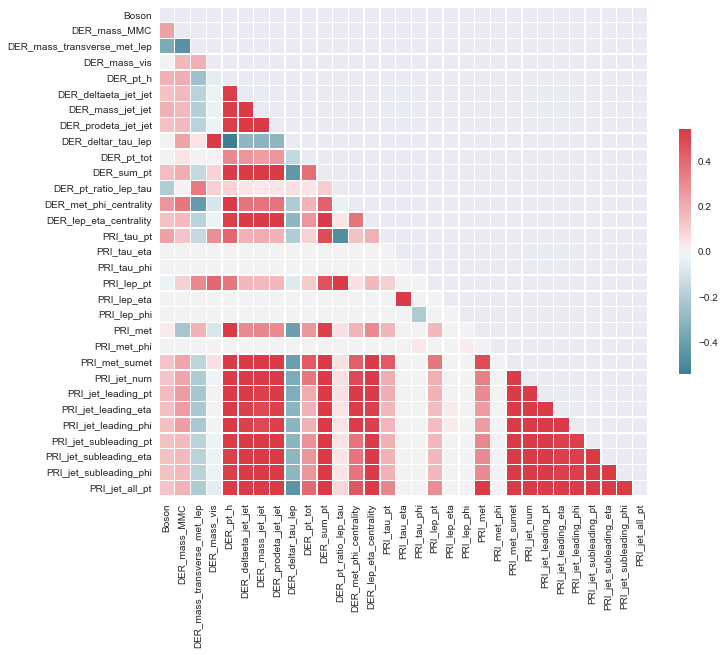

In [162]:
complete_data = np.append(np.array([y]).T,x,axis=1)
corr  = np.corrcoef(complete_data.T)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
xticks = np.append('Boson',labels)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=xticks, yticklabels=xticks);

array([ 138.47 ,   51.655,   97.827, ...,   99.405,    0.   ,    0.   ])

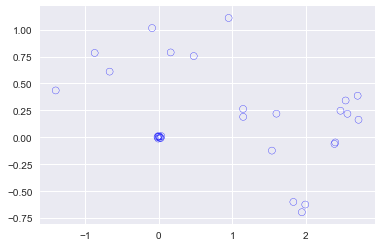

In [134]:
x_no = x.copy()
x_no[x_no == -999] = 0.0
corr = np.corrcoef(x_no.T)
eigenvalues, eigenvectors = la.eigh(corr)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
projection_s = corr.dot(eigenvectors[:,:4])
plt.scatter(projection_s[:,0],projection_s[:,1],facecolors='none',edgecolors='b')
# projection_b = corr.dot(eigenvectors[:,:4])
# plt.scatter(projection_b[:,0],projection_b[:,1],facecolors='none',edgecolors='g')

In [163]:
def summary_table(data):
    data = data.copy()
    data[data==-999] = np.nan
    data = {
        'Label':labels,
        'Min':np.nanmin(data,axis=0),
        'Q1':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Q3':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Max':np.nanmax(data,axis=0),
        'Median':np.nanmedian(data,axis=0),
        'Mean':np.nanmean(data,axis=0),
        'Std':np.nanstd(data,axis=0),
        'Missing': np.count_nonzero(np.isnan(data),axis=0)/data.shape[0]
    }
    numberFormatter =  NumberFormatter(format='0.000')
    source = ColumnDataSource(data)
    label_colum = TableColumn(field='Label', title='Label', width=150)
    columns = [label_colum] + [TableColumn(field=label, title=label, formatter=numberFormatter, width=80)\
               for label in [k for k in data.keys() if k != 'Label']]
    data_table = DataTable(source=source, columns=columns, width=900, height = 800)
    show(widgetbox(data_table, sizing_mode = 'scale_both'))
    
summary_table(x)

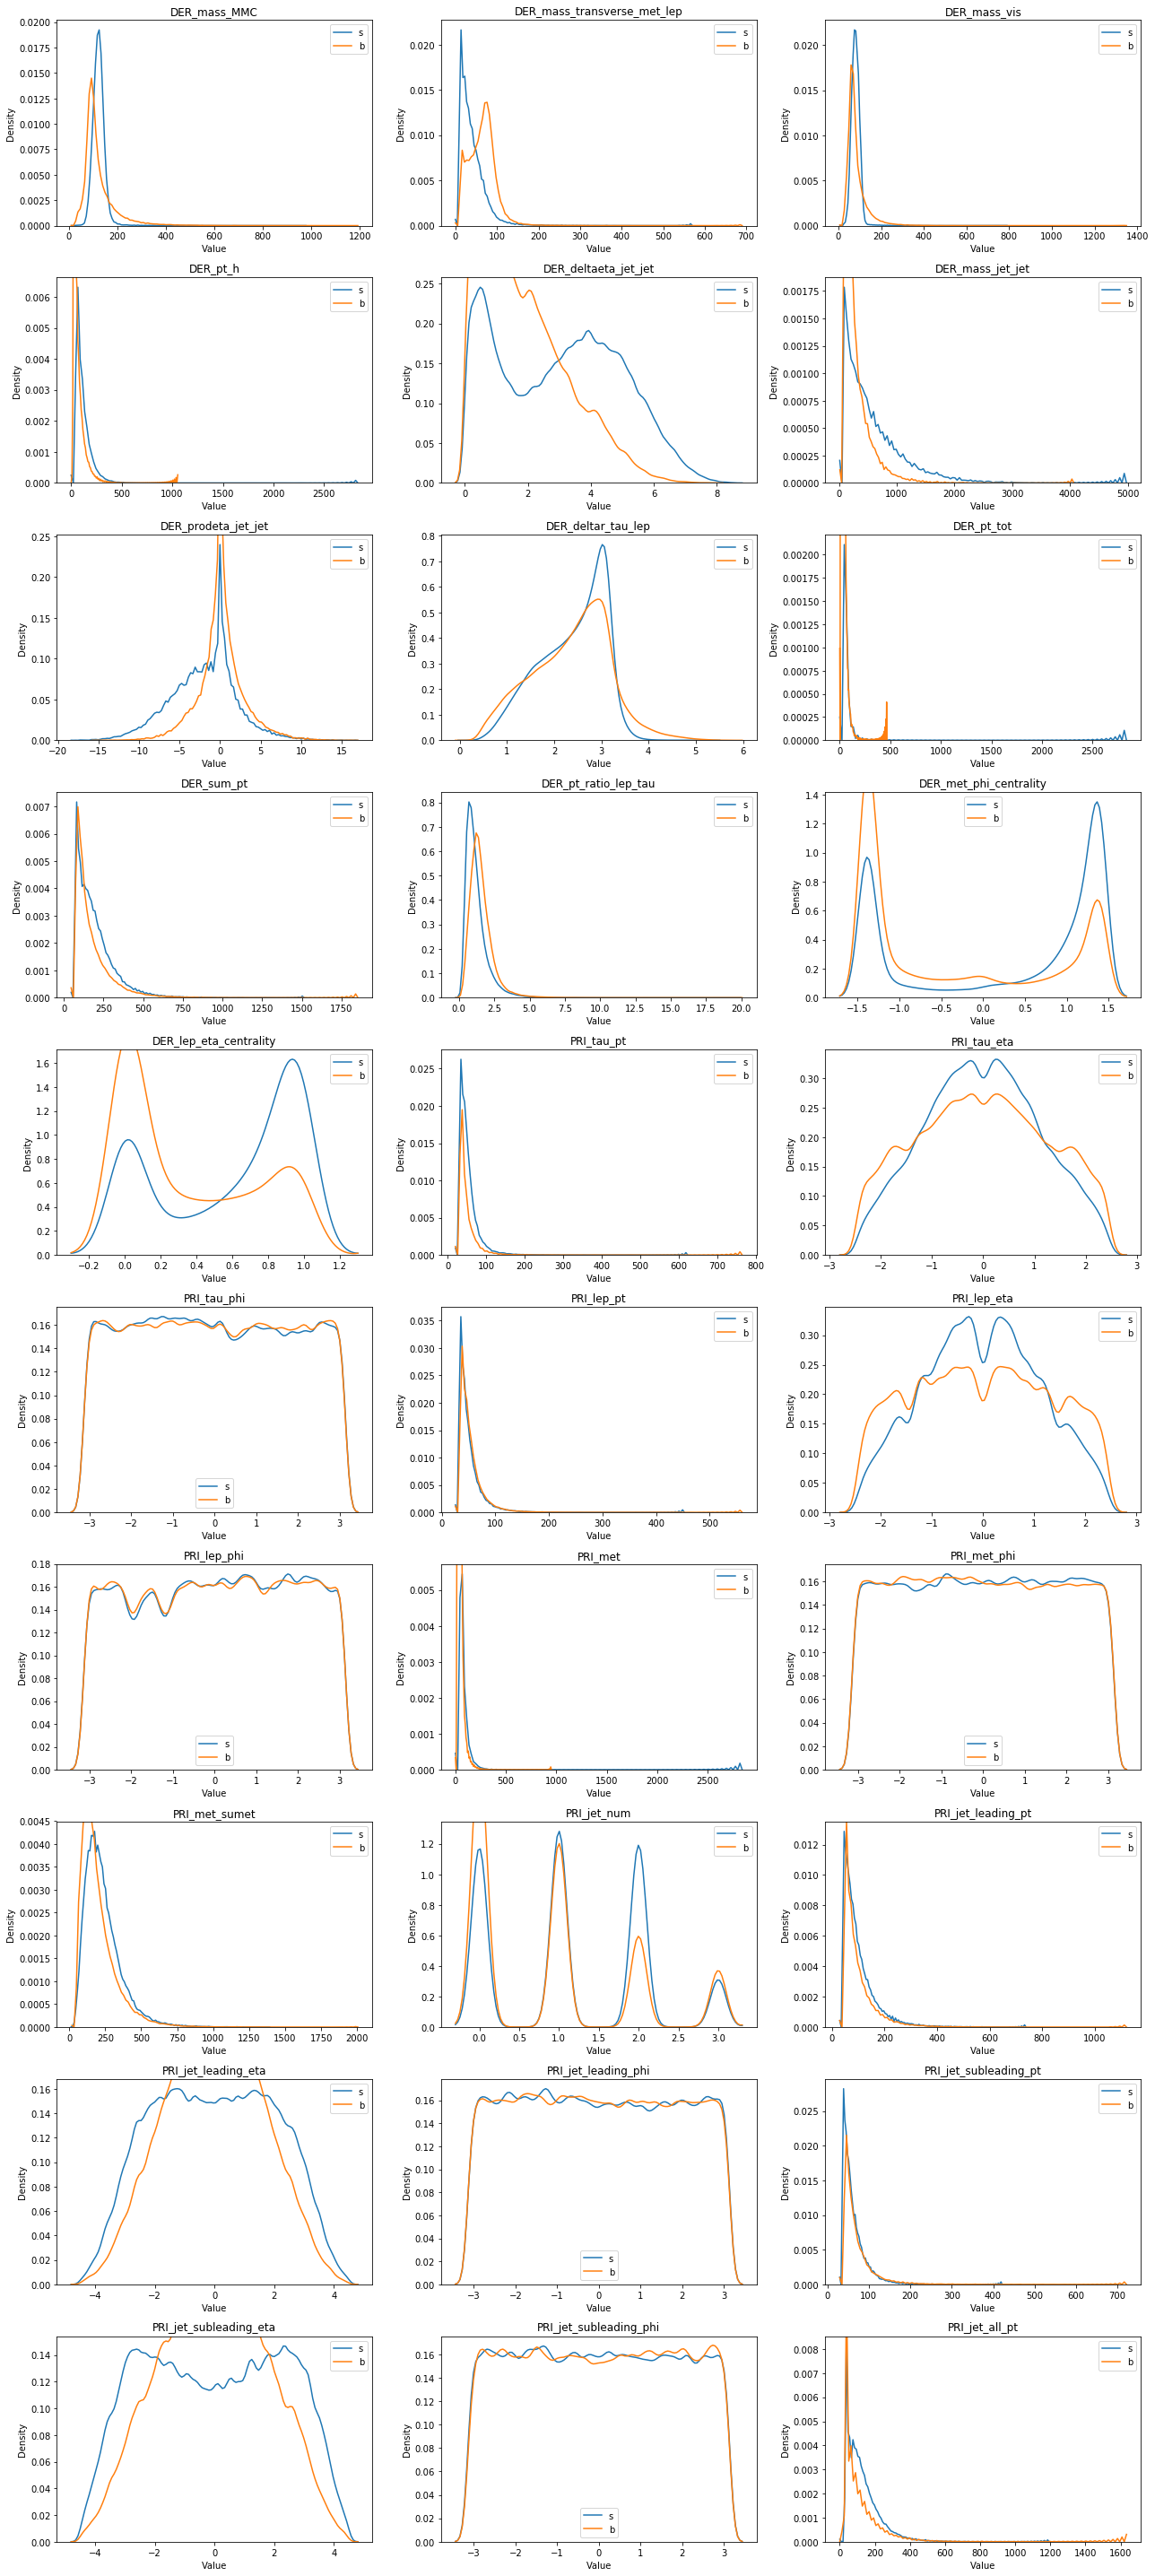

In [7]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [18,40]
for i, label in enumerate(labels):
    plt.subplot(10,3,i+1)
    values_s = x[y == 1]
    values_s = values_s[:,i]
    values_s[values_s==-999] = np.nan
#     plt.hist(values_s[~np.isnan(values_s)], label='s', histtype='step')
    sns.kdeplot(values_s[~np.isnan(values_s)], label='s', bw=0.1)
    
    values_b = x[y == -1]
    values_b = values_b[:,i]
    values_b[values_b==-999] = np.nan
#     plt.hist(values_b[~np.isnan(values_b)], label='b', histtype='step')
    sns.kdeplot(values_b[~np.isnan(values_b)], label='b',bw=0.1)
    plt.title(label)
    plt.ylabel('Density')
    plt.xlabel('Value')
plt.tight_layout()

In [4]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("mse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)

# Model building

In [5]:
y, x, ids = load_csv_data('../data/train.csv')
# x = (x - np.mean(x, axis=0))/np.std(x, axis=0)
num_samples = len(y)
tx = np.c_[np.ones(num_samples), x]

## Baseline
We create our baselines using cross validation, since it is only used to find the best value for a particular parameter using the whole data.
### Least squares GD

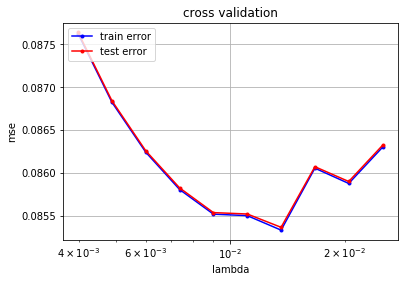

In [31]:
gammas = np.logspace(-2.4,-1.6,10)
mse_tr = []
mse_te = []
y_scaled = (y+1)/2.0
for gamma in gammas:
    mse_tr_, mse_te_ = cross_validation(y_scaled, x, 5, least_squares_GD, compute_mse, {'initial_w' : np.zeros(x.shape[1] + 1), 'max_iters':500, 'gamma':gamma})
    mse_tr.append(mse_tr_)
    mse_te.append(mse_te_)
cross_validation_visualization(gammas, mse_tr, mse_te)

In [32]:
print(np.vstack([gammas,mse_tr,mse_te]))

[[ 0.00398107  0.00488527  0.00599484  0.00735642  0.00902725  0.01107757
   0.01359356  0.01668101  0.02046968  0.02511886]
 [ 0.08761809  0.0868202   0.08623836  0.08580382  0.08551686  0.08549975
   0.0853309   0.08605289  0.08587492  0.08629688]
 [ 0.08763523  0.08683786  0.08625504  0.08582289  0.085535    0.08551884
   0.08536374  0.08607029  0.0858977   0.08631926]]


## Least squares SGD

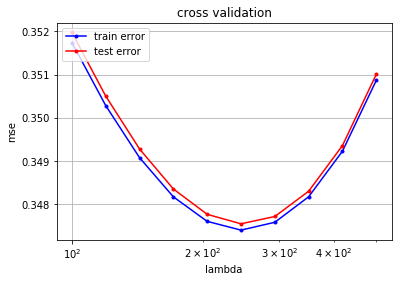

In [47]:
gammas = np.logspace(2,2.7,10)
mse_tr = []
mse_te = []
for gamma in gammas:
    mse_tr_, mse_te_ = cross_validation(y, x, 5, least_squares_SGD, compute_mse, {'initial_w' : np.zeros(x.shape[1]  + 1), 'max_iters':10000, 'gamma':gamma})
    mse_tr.append(mse_tr_)
    mse_te.append(mse_te_)
cross_validation_visualization(gammas, mse_tr, mse_te)

## Least squares normal equations

In [40]:
rmse_tr_, rmse_te_ = cross_validation(y, x, 5, least_squares, compute_mse, seed=5)

## Ridge regression

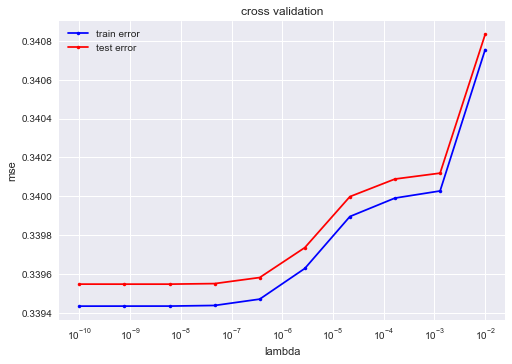

In [13]:
lambdas = np.logspace(-10,-2,10)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, x, 5, ridge_regression, compute_mse, {'lambda_': lambda_}, seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

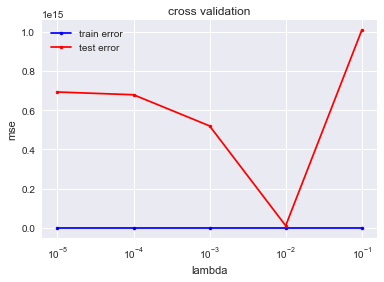

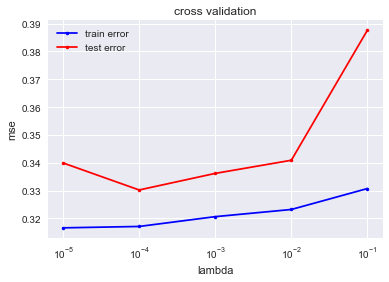

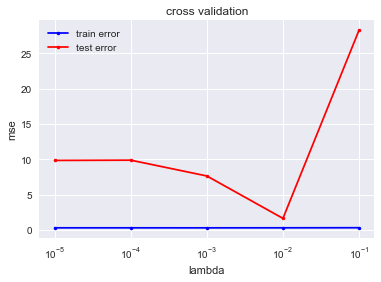

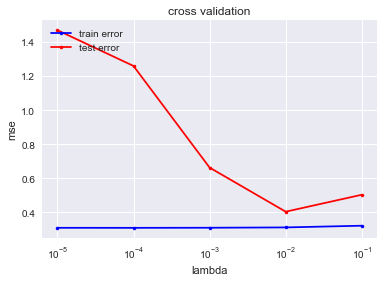

In [51]:
lambdas = np.logspace(-5,-1,5)

degree = 6
def x_y_for_jet(x, y):
    for n in range(4):
        jet_num = x[:, 22] == n
        x_jet = x[jet_num]
        y_jet = y[jet_num]
        jet_mean = np.mean(x_jet, axis=0)
        x_jet = x_jet[:, (jet_mean != -999) & (jet_mean != 0) & (jet_mean != n)]
        yield x_jet, y_jet
i = 0
for x_jet, y_jet in x_y_for_jet(x,y):
    plt.figure(i)
    rmse_tr = []
    rmse_te = []
    for lambda_ in lambdas:
        rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 5, ridge_regression_with_poly, compute_mse_with_poly, {'lambda_': lambda_, 'degree': degree}, {'degree': degree}, seed=5)
        rmse_tr.append(rmse_tr_)
        rmse_te.append(rmse_te_)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    plt.plot()
    i += 1

2


## Logisitic regression

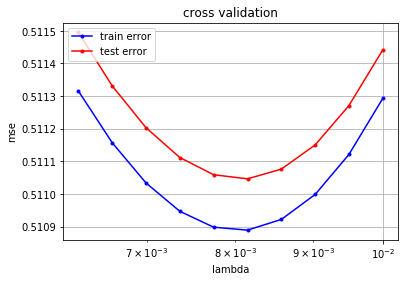

In [41]:
lambdas = np.logspace(-2.2,-2,10)
rmse_tr = []
rmse_te = []
y_scaled = (y+1)/2.0
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_scaled, x, 5, logistic_regression, compute_loss_logistic, {'initial_w': np.zeros(x.shape[1] + 1), 'max_iters': 10000, 'gamma': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [147]:
lambdas[np.argmin(rmse_te)]

0.0073564225445964136

## Regularized logistic regression

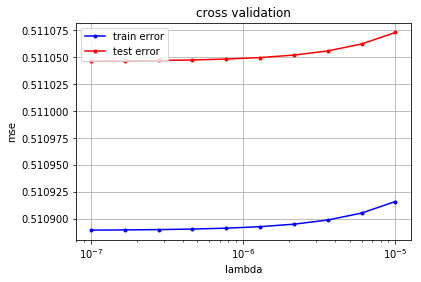

In [48]:
lambdas = np.logspace(-7,-5,10)
rmse_tr = []
rmse_te = []
y_scaled = (y+1)/2.0
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_scaled, x, 5, reg_logistic_regression, compute_loss_logistic_reg, {'lambda_': lambda_,'initial_w': np.zeros(x.shape[1] + 1), 'max_iters': 10000, 'gamma': 0.0081491274690207397}, {'lambda_': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [144]:
rmse_te

[0.51104651965027259,
 0.51104669898363742,
 0.51104699812787313,
 0.51104749712499653,
 0.51104832948764034,
 0.51104971791108489,
 0.51105203382606401,
 0.51105589668511742,
 0.51106233943238422,
 0.5110730841074288]

## Separating datasets

In [95]:
def index_of(label):
    return np.where(labels == label)[0][0]
print(index_of('PRI_jet_num'))
print(index_of('DER_deltaeta_jet_jet'))
print(index_of('DER_prodeta_jet_jet'))
print(index_of('DER_lep_eta_centrality'))
print(index_of('PRI_jet_leading_pt'))
print(index_of('PRI_jet_leading_eta'))
print(index_of('PRI_jet_leading_phi'))
print(index_of('PRI_jet_subleading_pt'))
print(index_of('PRI_jet_subleading_eta'))
print(index_of('PRI_jet_subleading_phi'))
print(index_of('DER_lep_eta_centrality'))
labels[22]

22
4
6
12
23
24
25
26
27
28
12


'PRI_jet_num'

In [139]:
def x_y_for_jet(n):
    jet_num = x[:, 22] == n
    x_jet = x[jet_num]
    y_jet = y[jet_num]
    jet_mean = np.mean(x_jet, axis=0)
    x_jet = x_jet[:, (jet_mean != -999) & (jet_mean != 0) & (jet_mean != n)]
    return x_jet, y_jet
jet_num = x[:, 22] == 0
x_jet_0 = x[jet_num]
y_jet_0 = y[jet_num]
jet_0_mean = np.mean(x_jet_0, axis=0)
np.where(jet_0_mean != 0)[0]
x_jet_0 = x_jet_0[:,(jet_0_mean != -999) & (jet_0_mean != 0)]
x_y_for_jet(3)[0].shape

(22164, 29)

At 0
At 1
At 2
At 3


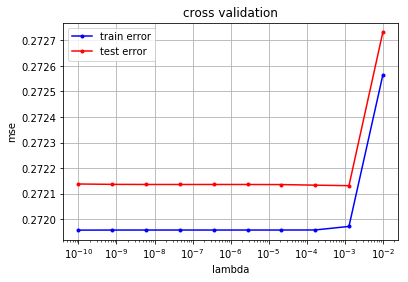

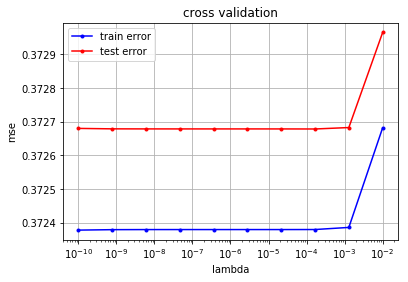

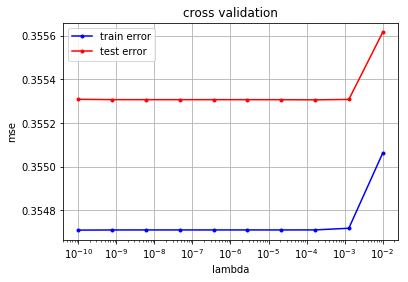

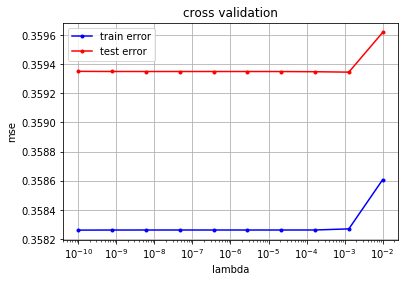

In [136]:
lambdas = np.logspace(-10,-2,10)
for n in range(4):
    rmse_tr = []
    rmse_te = []
    x_jet, y_jet = x_y_for_jet(n)
    for lambda_ in lambdas:
        rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 5, ridge_regression, compute_mse, {'lambda_': lambda_}, seed=5)
        rmse_tr.append(rmse_tr_)
        rmse_te.append(rmse_te_)
    plt.figure(n)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    plt.plot()
    print("At", n)

In [24]:
# y, x, ids = load_csv_data('../data/train.csv', sub_sample=True)
y, x, ids = load_csv_data('../data/train.csv')
filter_ = [idx for idx, label in enumerate(labels) if not 'phi' in label]
# x = x[:, filter_]
x = (x - np.mean(x, axis=0))/np.std(x, axis=0)
num_samples = len(y)
tx = np.c_[np.ones(num_samples), x]

In [22]:
y = (y+1)/2.0

In [19]:
lambdas = np.logspace(-7,-1,10)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, logistic_regression, compute_loss_logistic, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 100000, 'gamma': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

/home/raph/school/2017-2018/ml/ML_project/scripts/helpers.py:33: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(y.T @ np.log(sigma_xn_w) + (1-y).T @ np.log(1-sigma_xn_w))


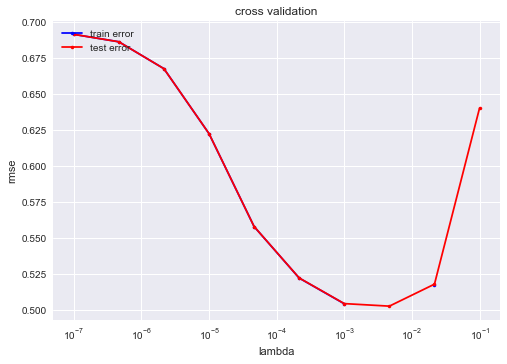

In [20]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [17]:
min(rmse_te)

0.50042407943911393

In [21]:
min(rmse_te)

0.50252559564073895

In [33]:
lambdas = np.logspace(-10,-1,5)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, reg_logistic_regression, compute_loss_logistic_reg, {'lambda_': lambda_,'initial_w': np.zeros(tx.shape[1]), 'max_iters': 10000, 'gamma': 0.001}, {'lambda_': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

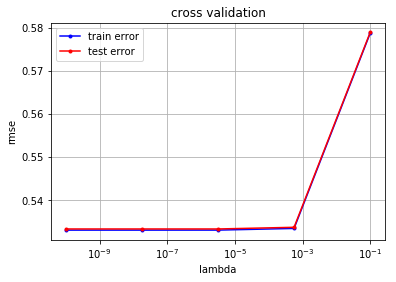

In [34]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [111]:
lambdas[np.argmin(rmse_te)]

0.001

In [48]:
lambdas = np.logspace(-10,-2,10)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, x, 5, ridge_regression, compute_mse, {'lambda_': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

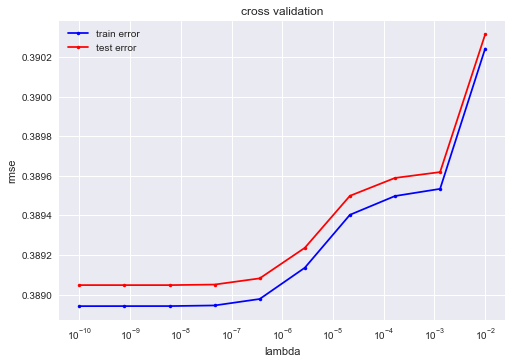

In [49]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [45]:
rmse_tr_, rmse_te_ = cross_validation(y, x, 5, least_squares, compute_mse)
print(rmse_tr_,rmse_te_)

0.388940931758 0.389052278846


0.38904858595820857

In [61]:
lambdas = np.logspace(-10,-1,5)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, least_squares_GD, compute_mse, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 10000, 'gamma': 0.1})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

In [79]:
rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, least_squares_GD, compute_mse, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 1000, 'gamma': 0.01})
print(rmse_tr_,rmse_te_)

Stopped at 999 iterations
Stopped at 999 iterations
Stopped at 999 iterations
Stopped at 999 iterations
Stopped at 999 iterations
0.0858090286377 0.0858265140568


In [84]:
rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, least_squares_SGD, compute_mse, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 1000000, 'gamma': 0.01})
print(rmse_tr_,rmse_te_)

0.160224664826 0.160226146812
